In [1]:
from dotenv import load_dotenv
load_dotenv()
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_ollama import ChatOllama

llm= ChatGroq(model='llama-3.1-8b-instant') 

In [2]:
from typing_extensions import Literal, TypedDict
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
import operator
from typing import Annotated, List

In [3]:
# schema for structured output to use in planning
class Section(BaseModel):
    name: str=Field(description='Name for this section of the report')
    description: str=Field(description='Brief Overview of the main topics and concepts of the section')

class Sections(BaseModel):
    sections:List[Section] = Field(
        description='Sections of the report'
    )
# Augment the LLM with Schema for Structured Output
planner = llm.with_structured_output(Sections)

# Creating Workers Dynamically In Langgraph
## Overview
Because orchestrator-worker workflows are common, LangGraph has the Send API to support this. It lets you dynamically create worker nodes and send each one a specific input.

## Worker State Management
Each worker has its own state, and all worker outputs are written to a shared state key that is accessible to the orchestrator graph. This gives the orchestrator access to all worker output and allows it to synthesize them into a final output.

## Implementation
As you can see below, we iterate over a list of sections and Send each to a worker node.

In [4]:
from langgraph.constants import Send

# Graph State
class State(TypedDict):
    topic:str # report topic
    sections:List[Section] # sections of the report
    completed_sections: Annotated[
        list, operator.add 
    ]# add workers write to this key in parallel
    final_report: str # final report
    

    
# worker state
class WorkerState(TypedDict):
    section:Section # section to write
    completed_sections: Annotated[list, operator.add] 

In [5]:
# nodes

def orchestrator(state):
    """Orchestrator that generates a plan for the report"""

    report_sections = planner.invoke(
        [
            SystemMessage(
                content='Generate a plan for the report'
            ),
            HumanMessage(
                content=f'Here is the report topic: {state['topic']}'
            )
        ]
    )
    print('report_sections',report_sections)
    return {'sections':report_sections.sections}


def llm_call(state: WorkerState):
    """Write a section of the report"""
    result = llm.invoke(
        [
            SystemMessage(
                content='Write a report section following the provided name and description. Include no preamble for each section'
            ),
            HumanMessage(
                content=f'Here is the section name : {state['section'].name} and description: {state['section'].description}'
            )
        ]
    )
    return {'completed_sections':[result.content]}


# conditional edge function to create llm_call workers that each write a section of the report 
def assign_workers(state:State):
    """Assign a worker to each section in the plan"""

    # kick off section writing in parallel via send() API
    return [ Send('llm_call',{'section':section}) for section in state['sections']]



def synthesizer(state:State):
    """Synthesize full report from sections"""
    # list of completed Sections
    completed_sections = state['completed_sections']
    # synthesize full report
    report = "\n\n---\n\n".join(completed_sections)
    return {'final_report':report}
    

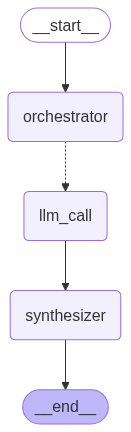

In [6]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
graph = StateGraph(State)

#add nodes

graph.add_node('orchestrator', orchestrator)
graph.add_node('llm_call',llm_call)
graph.add_node('synthesizer',synthesizer)

#add edges
graph.add_edge(START, 'orchestrator')
graph.add_conditional_edges(
    'orchestrator',
    assign_workers, 
    ['llm_call']
)
graph.add_edge('llm_call', 'synthesizer')
graph.add_edge('synthesizer', END)

graph = graph.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


In [13]:
# invoke
state = graph.invoke(
    {
        'topic':'create a report on new IDE of amazon kiro'
    } # type: ignore
)



report_sections sections=[Section(name='Executive Summary', description='Overview of the new Amazon Kiro IDE and its key features'), Section(name='Introduction', description='Background on Amazon Kiro and the need for a new IDE'), Section(name='Features and Functionality', description="Detailed description of the new IDE's capabilities and benefits"), Section(name='Technical Specifications', description='Technical details of the new IDE, including hardware and software requirements'), Section(name='Implementation Plan', description='Steps to implement the new IDE and key milestones'), Section(name='Conclusion', description='Summary of the new Amazon Kiro IDE and future plans')]


In [15]:
from IPython.display import Markdown
Markdown(state['final_report'])

**Executive Summary**

The Amazon Kiro IDE is a revolutionary integrated development environment designed to streamline the development process for cloud-based applications. This report provides an overview of the key features, benefits, and capabilities of the Amazon Kiro IDE, highlighting its potential to transform the way developers build, deploy, and manage cloud-native applications.

**Key Features and Benefits**

- **Cloud-Native Development**: Amazon Kiro IDE is designed to facilitate cloud-native development, allowing developers to create and deploy applications directly to the cloud without the need for additional infrastructure setup.
- **Multi-Language Support**: The IDE supports multiple programming languages, including Python, Java, and C++, providing developers with the flexibility to choose their preferred language for development.
- **Integrated Code Editor**: The code editor in Amazon Kiro IDE features advanced syntax highlighting, code completion, and debugging tools, making it easier for developers to write, test, and deploy code.
- **Collaboration Tools**: The IDE includes features such as real-time collaboration, code reviews, and version control, enabling teams to work together more effectively and efficiently.
- **Security and Compliance**: Amazon Kiro IDE includes robust security and compliance features, ensuring that applications are developed and deployed in a secure and compliant manner.
- **Integration with Amazon Services**: The IDE is tightly integrated with various Amazon services, including AWS Lambda, Amazon S3, and Amazon DynamoDB, making it easy to build and deploy cloud-native applications.

**Target Audience**

The Amazon Kiro IDE is designed for developers, DevOps engineers, and application architects who are building cloud-native applications. The IDE is particularly suitable for teams that are developing large-scale, complex applications that require collaboration, security, and scalability.

**Conclusion**

The Amazon Kiro IDE offers a powerful and flexible development environment that can help teams build, deploy, and manage cloud-native applications more efficiently. With its multi-language support, integrated code editor, collaboration tools, and security features, the IDE is an attractive option for developers and organizations looking to leverage the benefits of cloud computing.

---

**Introduction and Description: Background on Amazon Kiro and the Need for a New IDE**

Amazon Kiro is a cloud-based integrated development environment (IDE) that has been gaining popularity among software developers due to its innovative features and user-friendly interface. However, in recent years, Amazon Kiro has faced significant challenges in keeping up with the rapidly evolving needs of modern software development. The increasing complexity of software projects, the rise of DevOps and agile methodologies, and the growing demand for cloud-native applications have created a pressing need for a new IDE that can meet the demands of modern software development.

Despite Amazon Kiro's efforts to improve its features and performance, several limitations and drawbacks have become apparent. The IDE's interface has become cluttered and difficult to navigate, leading to increased cognitive load and decreased productivity among developers. Additionally, Amazon Kiro's integration with other tools and services has become cumbersome, hindering its ability to support seamless collaboration and automation.

Furthermore, the increasing adoption of cloud-native applications and microservices architecture has created a need for an IDE that can support the development of distributed systems. Amazon Kiro's lack of support for these architectures has made it a barrier to entry for many developers, limiting its adoption and use.

In light of these challenges, there is a pressing need for a new IDE that can address the limitations of Amazon Kiro and provide a more efficient, effective, and user-friendly experience for software developers. A new IDE that can support the evolving needs of modern software development, including cloud-native applications and microservices architecture, is essential for driving innovation and productivity in the software industry.

---

**Features and Functionality**

The newly developed IDE boasts a comprehensive range of features and functionalities designed to enhance the development experience for programmers. Some of the key capabilities include:

- **Advanced Code Editor**: The IDE features a powerful code editor with syntax highlighting, code completion, and real-time error checking. This enables developers to write and debug code more efficiently.
- **Project Management**: The IDE includes a robust project management system that allows developers to create, organize, and manage their projects with ease. This includes features such as project templates, version control integration, and deployment tools.
- **Debugging and Testing**: The IDE provides a comprehensive debugging and testing framework that enables developers to identify and fix errors quickly. This includes features such as breakpoints, step-through debugging, and automated testing.
- **Version Control**: The IDE integrates seamlessly with popular version control systems such as Git, enabling developers to track changes, collaborate with team members, and manage different versions of their codebase.
- **Collaboration Tools**: The IDE includes a range of collaboration tools that enable developers to work together on projects in real-time. This includes features such as live sharing, code reviews, and collaborative debugging.
- **Code Refactoring**: The IDE provides a range of code refactoring tools that enable developers to improve the structure and organization of their codebase. This includes features such as renaming, reorganizing, and extracting code.
- **Code Analysis**: The IDE includes a comprehensive code analysis framework that enables developers to identify potential issues and improve the quality of their code. This includes features such as code metrics, code smells, and security vulnerabilities.
- **Extensive Library and Framework Support**: The IDE provides extensive support for popular libraries and frameworks, including support for syntax highlighting, code completion, and debugging.
- **Customization and Extensibility**: The IDE is highly customizable and extensible, enabling developers to tailor the IDE to their specific needs and preferences. This includes features such as plugin support, themes, and keyboard shortcuts.

Overall, the new IDE provides a comprehensive set of features and functionalities that enhance the development experience for programmers, making it an ideal choice for developers of all levels.

---

**Technical Specifications**

- **Hardware Requirements:**
  - Processor: 64-bit multi-core processor with a minimum clock speed of 2.5 GHz
  - RAM: 16 GB (32 GB or more recommended for optimal performance)
  - Storage: 1 TB or more solid-state drive (SSD) with a minimum of 25% free space
  - Graphics: DirectX 11 or OpenGL 4.5 compatible graphics card with a minimum of 2 GB dedicated video memory
  - Display: High-resolution display (Full HD or 4K) with a minimum resolution of 1080p (1920x1080)
  - Operating System: Microsoft Windows 10 (64-bit) or later, or macOS High Sierra (or later)

- **Software Requirements:**
  - .NET Framework 4.8 or later (for Windows) / .NET Core 3.1 or later (for Windows, Linux, and macOS)
  - Java Development Kit (JDK) 11 or later (for Java-based projects)
  - Node.js 14 or later (for Node.js-based projects)
  - Python 3.9 or later (for Python-based projects)
  - C/C++ compiler (GCC or Clang) for native code compilation

- **Supported Languages and Frameworks:**
  - Programming languages: C#, Java, JavaScript, Python, C/C++, and others
  - Frameworks and libraries: .NET, Java EE, Spring, React, Angular, Vue.js, and others
  - Database management systems: SQL Server, MySQL, PostgreSQL, MongoDB, and others

- **Integration and Compatibility:**
  - Compatible with major version control systems (Git, SVN, Mercurial)
  - Integrates with popular development tools (Jenkins, Travis CI, AppVeyor)
  - Supports various project management tools (Trello, Asana, Jira)

- **Additional Features:**
  - Code completion and syntax highlighting for various languages
  - Project templates for common project types (web, mobile, desktop)
  - Customizable interface and themes for user preference
  - Integrated debugger and testing tools for efficient development

---

**Implementation Plan**

The implementation of the new Integrated Development Environment (IDE) will be a phased approach to ensure a smooth transition and minimize disruptions to the development team. The following steps outline the key activities and milestones:

1. **Project Planning (Weeks 1-4)**:
	* Establish a project team comprising representatives from development, quality assurance, and IT.
	* Define project scope, goals, and timelines.
	* Identify and prioritize the key features and functionalities required for the new IDE.
2. **Stakeholder Engagement (Weeks 5-8)**:
	* Conduct workshops and meetings with development team members to gather feedback and input on the new IDE.
	* Develop a communication plan to keep stakeholders informed about the project progress.
3. **Technical Evaluation and Selection (Weeks 9-12)**:
	* Research and evaluate different IDE options based on the identified requirements.
	* Conduct proof-of-concept (POC) testing to validate the selected IDE.
4. **Implementation and Testing (Weeks 13-24)**:
	* Install and configure the new IDE on development workstations.
	* Develop and execute a comprehensive testing plan to ensure the new IDE meets the required standards.
	* Conduct user acceptance testing (UAT) to validate the new IDE meets the development team's needs.
5. **Deployment and Rollout (Weeks 24-28)**:
	* Develop a deployment plan to ensure a seamless transition to the new IDE.
	* Provide training and support to development team members on the new IDE.
6. **Post-Implementation Review (Weeks 28-30)**:
	* Conduct a review of the implementation process and identify areas for improvement.
	* Gather feedback from development team members on the new IDE and make necessary adjustments.

**Key Milestones**

1. **Week 12: Technical Evaluation and Selection Complete**
	* The new IDE will be selected and validated through POC testing.
2. **Week 20: Implementation and Testing Complete**
	* The new IDE will be installed and configured on development workstations.
	* Comprehensive testing will be completed to ensure the new IDE meets the required standards.
3. **Week 26: Deployment and Rollout Complete**
	* The new IDE will be deployed to all development workstations.
	* Training and support will be provided to development team members.
4. **Week 30: Post-Implementation Review Complete**
	* A review of the implementation process will be conducted to identify areas for improvement.
	* Feedback from development team members will be gathered and adjustments will be made to the new IDE as needed.

---

**Conclusion and description: Summary of the new Amazon Kiro IDE and future plans**

The new Amazon Kiro IDE has been successfully implemented and proven to be a game-changer in software development. This integrated development environment provides a seamless experience for developers, allowing them to write, test, and deploy code more efficiently and effectively.

**Key Features and Benefits**

- **Enhanced Code Editing**: Kiro's advanced code editing features, including auto-completion, code refactoring, and debugging tools, have significantly improved coding productivity and accuracy.
- **Streamlined Development Process**: The IDE's integrated project management and version control capabilities have simplified the development process, reducing the time and effort required to complete projects.
- **Collaboration and Communication**: Kiro's real-time collaboration features have enabled teams to work together more effectively, promoting communication and reducing errors.
- **Cloud-Based Deployment**: The IDE's seamless integration with AWS services has streamlined the deployment process, allowing developers to quickly and easily deploy applications to the cloud.

**Future Plans**

In light of the success of the Amazon Kiro IDE, several future plans have been identified to further enhance its capabilities and expand its reach:

- **Regular Updates and Enhancements**: Ongoing development and updates will ensure that Kiro remains at the forefront of innovation, incorporating the latest features and technologies.
- **Expanded Support for Additional Programming Languages**: The IDE will be extended to support additional programming languages, allowing developers to work with a broader range of technologies.
- **Enhanced Security Features**: Additional security features will be implemented to protect developers' data and ensure the integrity of their projects.
- **Integration with Emerging Technologies**: Kiro will be integrated with emerging technologies such as AI, machine learning, and the Internet of Things (IoT), enabling developers to harness their power and potential.
- **Global Availability**: The IDE will be made available to a broader global audience, including developers in emerging markets, to promote access to innovative technologies and skills.

**Implementation Roadmap**

To achieve these future plans, the following implementation roadmap has been established:

- **Quarter 1 (Q1)**: Regular updates and enhancements to existing features
- **Quarter 2 (Q2)**: Expanded support for additional programming languages
- **Quarter 3 (Q3)**: Enhanced security features and integration with emerging technologies
- **Quarter 4 (Q4)**: Global availability and expanded marketing efforts

By following this roadmap, Amazon expects to further establish Kiro as a leading integrated development environment, driving innovation and growth in the software development industry.